<a href="https://colab.research.google.com/github/dbtjr1103/project_V8/blob/main/%EC%9E%A5%EA%B8%B0%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_main_%EC%9C%A0%EC%A0%9C10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요

목표 : 유제품 10가지를 선정해서 모델 학습 후 앱연동까지 진행

사용모델 : yolov8 nano

데이터셋 : https://universe.roboflow.com/dairy10/dairy10s

aihub데이터 + 바나나우유 추가, 큰 객체 데이터만 사용하며 자체 augmentation으로 작은 객체 데이터 증강 


## library 설치

In [ ]:
!pip install ultralytics==8.0.4
!pip install roboflow

In [ ]:
from IPython import display
display.clear_output()
!yolo mode=checks

from ultralytics import YOLO

from IPython.display import display, Image

Ultralytics YOLOv8.0.4 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 23.0/166.8 GB disk)


# 데이터

## 데이터셋 다운

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
cd /content

/content


In [ ]:
rm -rf dairy10s-2

In [ ]:
from PIL import Image

In [ ]:
image('/content/dairy-1/train/images/-11-_jpg.rf.69448cfd26532bb80edd3fb107d1e85a.jpg')

NameError: ignored

In [1]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="p4uwpuA6E4He7pwdfd3E")
project = rf.workspace("dairy10").project("dairy-mbfss")
dataset = project.version(2).download("yolov8")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 8.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=9737c35554506b6f22a9444b7d3c9eef1d38ff2753641417ace1b50eb38cac8e
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pypars

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to dairy-2 in yolov8:: 100%|██████████| 1524/1524 [00:00<00:00, 8544.86it/s]


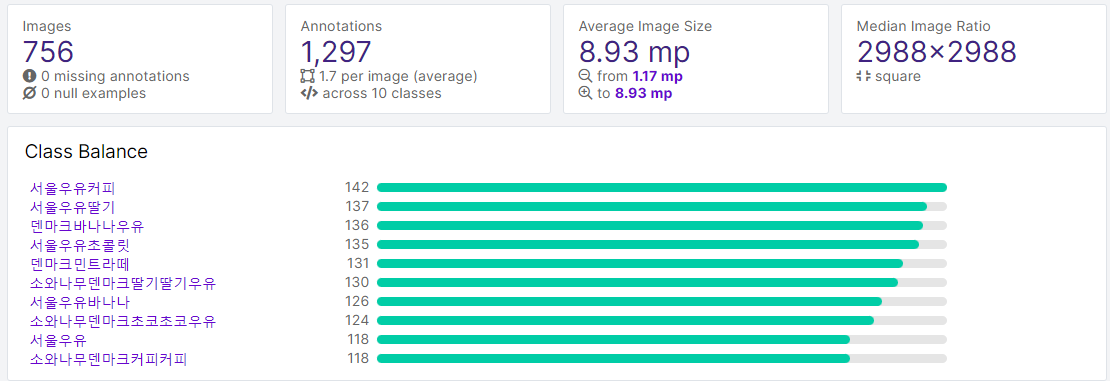

data.yaml파일 수정 

names:
- 바나나맛우유
- 덴마크바나바나
- 덴마크초코초코
- 덴마크커피커피
- 덴마크딸기딸기
- 서울우유바나나
- 서울우유초콜렛
- 서울우유커피
- 서울우유
- 서울우유딸기

## 데이터 증강



In [2]:
%cd /content/dairy-2
!mkdir train_aug
!mkdir valid_aug
%cd /content/dairy-2/train_aug
!mkdir images
!mkdir labels
%cd /content/dairy-2/valid_aug
!mkdir images
!mkdir labels

/content/dairy-2
/content/dairy-2/train_aug
/content/dairy-2/valid_aug


In [ ]:
%cd /content/dairy10s-2
!mkdir train_aug2
!mkdir valid_aug2
%cd /content/dairy10s-2/train_aug2
!mkdir images
!mkdir labels
%cd /content/dairy10s-2/valid_aug2
!mkdir images
!mkdir labels

/content/dairy10s-2
/content/dairy10s-2/train_aug2
/content/dairy10s-2/valid_aug2


In [ ]:
# 폴더생성

In [ ]:
%cd /content/drive/MyDrive/dairy10s-3
!mkdir train_aug
!mkdir valid_aug
%cd /content/drive/MyDrive/dairy10s-3/train_aug
!mkdir images
!mkdir labels
%cd /content/drive/MyDrive/dairy10s-3/valid_aug
!mkdir images
!mkdir labels

/content/drive/MyDrive/dairy10s-3
/content/drive/MyDrive/dairy10s-3/train_aug
/content/drive/MyDrive/dairy10s-3/valid_aug


### 함수

#### trainset

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from tqdm.notebook import tqdm

def crop_12(path_im,path_lb,iter_num):
    all_img = glob.glob(path_im + '/*.jpg') # 이미지 경로
    all_lbl = glob.glob(path_lb + '/*.txt') # 라벨 경로
    all_img.sort()
    all_lbl.sort() 
    for number in range(iter_num):
        data_list = random.sample(range(len(all_img)), 12)# 전체 경로의 파일수 중 12개 랜덤추출
        im_paths = [all_img[i] for i in data_list]
        lb_paths = [all_lbl[i] for i in data_list]
        # 라벨 담아줄 딕셔너리 / minmax는 박스 그리려고 생성
        new_label_dic = {'new_label_json': [], 'new_label_txt':[], 'new_label_minmax':[]}
        with open('/content/dairy-2/train_aug/labels' + f'/concat12_image{number}.txt', "a") as f:
            f.truncate(0)
        for idx,(img_path,label_path) in enumerate(zip(im_paths,lb_paths)):
            # Load image
            plt.axis("off") # 축 제거
            img = cv2.imread(img_path)
            with open(label_path, "r") as f:
                data = f.readline()
            list_data = data.strip().split(' ')
            # 로보플로로 크롭한 이미지 -> 센터와 너비 높이로 구성
            x_center = 640*float(list_data[1])
            y_center = 640*float(list_data[2])
            width = 640*float(list_data[3])
            height = 640*float(list_data[4])
            # minmax 형식으로 변환
            ogn_x_min = x_center - (width/2)
            ogn_x_max = x_center + (width/2)
            ogn_y_min = y_center - (height/2)
            ogn_y_max = y_center + (height/2)
            # 새로운 라벨 사전작업 좌표이동 전
            bf_x_min = 0
            bf_x_max = ogn_x_max - ogn_x_min
            bf_y_min = 0
            bf_y_max = ogn_y_min - ogn_y_max
            # 라벨 txt 형식 좌표이동 전
            bf_ctr_x = (bf_x_max + bf_x_min) / 2
            bf_ctr_y = (bf_y_max + bf_y_min) / 2
            bf_width = bf_x_max
            bf_height = bf_y_max
            # 새로운 라벨 
            if idx < 6: # 위 이미지
                af_y_min = 20 # 패딩 준 만큽 
                af_y_max = 20 + 250
                af_x_min = idx*105 + 5
                af_x_max = idx*105 + 110
            else: # 아래 이미지
                af_y_min = 320 + 20
                af_y_max = 320 + 20 + 250
                af_x_min = (idx-6)*105 + 5
                af_x_max = (idx-6)*105 + 110
            # 새로운 라벨 - json 후
            af_ctr_x = (af_x_max + af_x_min) / 2
            af_ctr_y = (af_y_max + af_y_min) / 2
            af_width = af_x_max - af_x_min
            af_height = af_y_max - af_y_min
            # 새로운 라벨 비율 - txt 후
            ratio_x = af_ctr_x / 640
            ratio_y = af_ctr_y / 640
            ratio_width = af_width / 640
            ratio_height = af_height / 640
            # 박스 그리기용 
            new_label_minmax = f'{list_data[0]} {af_x_min} {af_x_max} {af_y_min} {af_y_max}'
            # json 라벨  x_min y_min x_max y_max
            new_label_json = f'{list_data[0]} {af_ctr_x} {af_ctr_y} {af_width} {af_height}' 
            # txt 라벨  x y width height
            new_label_txt = f'{list_data[0]} {ratio_x} {ratio_y} {ratio_width} {ratio_height}'
            # 라벨들 저장
            new_label_dic['new_label_json'].append(new_label_json)
            new_label_dic['new_label_txt'].append(new_label_txt)
            new_label_dic['new_label_minmax'].append(new_label_minmax)
            with open('/content/dairy-2/train_aug/labels' + f'/concat12_image{number}.txt','a') as f:
                if idx == 11:
                    f.write(new_label_txt)
                else:
                    f.write(new_label_txt + '\n')
            #Cropped data(이미지 라벨로 크롭 후 자르기)
            start = (int(ogn_y_min),int(ogn_x_min))
            end = (int(ogn_y_max),int(ogn_x_max))
            output = np.zeros((end[0]-start[0], end[1]-start[1], 3), np.uint8)
            for y in range(output.shape[1]):
                for x in range(output.shape[0]):
                    xp, yp = x + start[0], y+start[1]
                    output[x,y] = img[xp,yp]
            if idx == 0: # 1행 6열 2개를 합치는 방식
                concat_img1 = output # 처음 크롭한 것은 concat1에 적절한 이미지 크기로 넣어줌
                concat_img1 = cv2.resize(concat_img1,(105,300))
            elif idx > 0 and idx < 6: # 2-6번째 이미지는 리사이즈 후 합침
                output = cv2.resize(output,(105,300))
                concat_img1 = cv2.hconcat([concat_img1,output]) # 가로로 합치는 코드
            elif idx == 6:
                concat_img1 = cv2.rectangle(concat_img1, (0, 320), (640, 250), (0, 0, 0), -1) # concat1 아래부분 가리기
                concat_img1 = cv2.copyMakeBorder(concat_img1,20,0,5,5,cv2.BORDER_CONSTANT) # concat1의 패딩
                concat_img2 = output # 2행 1열 이미지
                concat_img2 = cv2.resize(concat_img2,(105,300))
            elif idx == 11: # 마지막 concat후
                output = cv2.resize(output,(105,300))
                concat_img2 = cv2.hconcat([concat_img2,output])
                concat_img2 = cv2.rectangle(concat_img2, (0, 320), (640, 250), (0, 0, 0), -1) # concat2 아래부분 가리기
                concat_img2 = cv2.copyMakeBorder(concat_img2,20,0,5,5,cv2.BORDER_CONSTANT) # concat2의 패딩
            else: # 2행 나머지 concat2에 합치기
                output = cv2.resize(output,(105,300))
                concat_img2 = cv2.hconcat([concat_img2,output])
        # 만들어지 1행 6열 2개를 세로로 합침
        concat_img = cv2.vconcat([concat_img1,concat_img2])
        # print(concat_img.shape) # 크기확인
        # box 쳐주기 예시
        # for label in new_label_dic['new_label_minmax']:
        #     # print(label)
        #     label = label.split(' ')
        #     concat_img = cv2.rectangle(concat_img, (int(label[1]), int(label[3])),(int(label[2]), int(label[4])), (0, 255, 0), 2)
        # plt.imshow(concat_img)
        cv2.imwrite('/content/dairy-2/train_aug/images' + f'/concat12_image{number}.jpg',concat_img)

#### valid set

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from tqdm.notebook import tqdm

def crop_12(path_im,path_lb,iter_num):
    all_img = glob.glob(path_im + '/*.jpg') # 이미지 경로
    all_lbl = glob.glob(path_lb + '/*.txt') # 라벨 경로
    all_img.sort()
    all_lbl.sort() 
    for number in tqdm(range(iter_num)):
        data_list = random.sample(range(len(all_img)), 12)# 전체 경로의 파일수 중 12개 랜덤추출
        im_paths = [all_img[i] for i in data_list]
        lb_paths = [all_lbl[i] for i in data_list]
        # 라벨 담아줄 딕셔너리 / minmax는 박스 그리려고 생성
        new_label_dic = {'new_label_json': [], 'new_label_txt':[], 'new_label_minmax':[]}
        with open('/content/dairy-2/valid_aug/labels' + f'/concat12_image{number}.txt', "a") as f:
            f.truncate(0)
        for idx,(img_path,label_path) in enumerate(zip(im_paths,lb_paths)):
            # Load image
            plt.axis("off") # 축 제거
            img = cv2.imread(img_path)
            with open(label_path, "r") as f:
                data = f.readline()
            list_data = data.strip().split(' ')
            # 로보플로로 크롭한 이미지 -> 센터와 너비 높이로 구성
            x_center = 640*float(list_data[1])
            y_center = 640*float(list_data[2])
            width = 640*float(list_data[3])
            height = 640*float(list_data[4])
            # minmax 형식으로 변환
            ogn_x_min = x_center - (width/2)
            ogn_x_max = x_center + (width/2)
            ogn_y_min = y_center - (height/2)
            ogn_y_max = y_center + (height/2)
            # 새로운 라벨 사전작업 좌표이동 전
            bf_x_min = 0
            bf_x_max = ogn_x_max - ogn_x_min
            bf_y_min = 0
            bf_y_max = ogn_y_min - ogn_y_max
            # 라벨 txt 형식 좌표이동 전
            bf_ctr_x = (bf_x_max + bf_x_min) / 2
            bf_ctr_y = (bf_y_max + bf_y_min) / 2
            bf_width = bf_x_max
            bf_height = bf_y_max
            # 새로운 라벨 
            if idx < 6: # 위 이미지
                af_y_min = 20 # 패딩 준 만큽 
                af_y_max = 20 + 250
                af_x_min = idx*105 + 5
                af_x_max = idx*105 + 110
            else: # 아래 이미지
                af_y_min = 320 + 20
                af_y_max = 320 + 20 + 250
                af_x_min = (idx-6)*105 + 5
                af_x_max = (idx-6)*105 + 110
            # 새로운 라벨 - json 후
            af_ctr_x = (af_x_max + af_x_min) / 2
            af_ctr_y = (af_y_max + af_y_min) / 2
            af_width = af_x_max - af_x_min
            af_height = af_y_max - af_y_min
            # 새로운 라벨 비율 - txt 후
            ratio_x = af_ctr_x / 640
            ratio_y = af_ctr_y / 640
            ratio_width = af_width / 640
            ratio_height = af_height / 640
            # 박스 그리기용 
            new_label_minmax = f'{list_data[0]} {af_x_min} {af_x_max} {af_y_min} {af_y_max}'
            # json 라벨  x_min y_min x_max y_max
            new_label_json = f'{list_data[0]} {af_ctr_x} {af_ctr_y} {af_width} {af_height}' 
            # txt 라벨  x y width height
            new_label_txt = f'{list_data[0]} {ratio_x} {ratio_y} {ratio_width} {ratio_height}'
            # 라벨들 저장
            new_label_dic['new_label_json'].append(new_label_json)
            new_label_dic['new_label_txt'].append(new_label_txt)
            new_label_dic['new_label_minmax'].append(new_label_minmax)
            with open('/content/dairy-2/valid_aug/labels' + f'/concat12_image{number}.txt','a') as f:
                if idx == 11:
                    f.write(new_label_txt)
                else:
                    f.write(new_label_txt + '\n')
            #Cropped data(이미지 라벨로 크롭 후 자르기)
            start = (int(ogn_y_min),int(ogn_x_min))
            end = (int(ogn_y_max),int(ogn_x_max))
            output = np.zeros((end[0]-start[0], end[1]-start[1], 3), np.uint8)
            for y in range(output.shape[1]):
                for x in range(output.shape[0]):
                    xp, yp = x + start[0], y+start[1]
                    output[x,y] = img[xp,yp]
            if idx == 0: # 1행 6열 2개를 합치는 방식
                concat_img1 = output # 처음 크롭한 것은 concat1에 적절한 이미지 크기로 넣어줌
                concat_img1 = cv2.resize(concat_img1,(105,300))
            elif idx > 0 and idx < 6: # 2-6번째 이미지는 리사이즈 후 합침
                output = cv2.resize(output,(105,300))
                concat_img1 = cv2.hconcat([concat_img1,output]) # 가로로 합치는 코드
            elif idx == 6:
                concat_img1 = cv2.rectangle(concat_img1, (0, 320), (640, 250), (0, 0, 0), -1) # concat1 아래부분 가리기
                concat_img1 = cv2.copyMakeBorder(concat_img1,20,0,5,5,cv2.BORDER_CONSTANT) # concat1의 패딩
                concat_img2 = output # 2행 1열 이미지
                concat_img2 = cv2.resize(concat_img2,(105,300))
            elif idx == 11: # 마지막 concat후
                output = cv2.resize(output,(105,300))
                concat_img2 = cv2.hconcat([concat_img2,output])
                concat_img2 = cv2.rectangle(concat_img2, (0, 320), (640, 250), (0, 0, 0), -1) # concat2 아래부분 가리기
                concat_img2 = cv2.copyMakeBorder(concat_img2,20,0,5,5,cv2.BORDER_CONSTANT) # concat2의 패딩
            else: # 2행 나머지 concat2에 합치기
                output = cv2.resize(output,(105,300))
                concat_img2 = cv2.hconcat([concat_img2,output])
        # 만들어지 1행 6열 2개를 세로로 합침
        concat_img = cv2.vconcat([concat_img1,concat_img2])
        # print(concat_img.shape) # 크기확인
        # box 쳐주기 예시
        # for label in new_label_dic['new_label_minmax']:
        #     # print(label)
        #     label = label.split(' ')
        #     concat_img = cv2.rectangle(concat_img, (int(label[1]), int(label[3])),(int(label[2]), int(label[4])), (0, 255, 0), 2)
        # plt.imshow(concat_img)
        cv2.imwrite('/content/dairy-2/valid_aug/images' + f'/concat12_image{number}.jpg',concat_img)

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from tqdm.notebook import tqdm

def crop_48(path_im,path_lb,iter_num):
    all_img = glob.glob(path_im + '/*.jpg') # 이미지 경로
    all_lbl = glob.glob(path_lb + '/*.txt') # 라벨 경로
    all_img.sort()
    all_lbl.sort() 
    for number in tqdm(range(iter_num)):
        data_list = random.sample(range(len(all_img)), 48)# 전체 경로의 파일수 중 12개 랜덤추출
        im_paths = [all_img[i] for i in data_list]
        lb_paths = [all_lbl[i] for i in data_list]
        # 라벨 담아줄 딕셔너리 / minmax는 박스 그리려고 생성
        new_label_dic = {'new_label_json': [], 'new_label_txt':[], 'new_label_minmax':[]}
        with open('/content/dairy-2/valid_aug/labels' + f'/concat48_image{number}.txt', "a") as f:
            f.truncate(0)
        for idx,(img_path,label_path) in enumerate(zip(im_paths,lb_paths)):
            # Load image
            plt.axis("off") # 축 제거
            img = cv2.imread(img_path)
            with open(label_path, "r") as f:
                data = f.readline()
            list_data = data.strip().split(' ')
            # minmax 형식으로 변환
            ogn_x_min = 640*float(list_data[1]) - (640*float(list_data[3])/2)
            ogn_x_max = 640*float(list_data[1]) + (640*float(list_data[3])/2)
            ogn_y_min = 640*float(list_data[2]) - (640*float(list_data[4])/2)
            ogn_y_max = 640*float(list_data[2]) + (640*float(list_data[4])/2)
            # 라벨 txt 형식 좌표이동 전
            bf_ctr_x = (ogn_x_max - ogn_x_min + 0) / 2
            bf_ctr_y = (ogn_y_min - ogn_y_max + 0) / 2
            bf_width = ogn_x_max - ogn_x_min
            bf_height = ogn_y_min - ogn_y_max
            # 새로운 라벨         
            af_y_min = 160*(idx//12) + 10
            af_y_max = 160*(idx//12) + 10 + 125
            af_x_min = (idx-12*(idx//12))*53 + 2
            af_x_max = (idx-12*(idx//12))*53 + 55
            # 새로운 라벨 - json 후
            af_ctr_x = (af_x_max + af_x_min) / 2
            af_ctr_y = (af_y_max + af_y_min) / 2
            af_width = af_x_max - af_x_min
            af_height = af_y_max - af_y_min
            # 새로운 라벨 비율 - txt 후
            ratio_x = af_ctr_x / 640
            ratio_y = af_ctr_y / 640
            ratio_width = af_width / 640
            ratio_height = af_height / 640
            # 박스 그리기용 
            new_label_minmax = f'{list_data[0]} {af_x_min} {af_x_max} {af_y_min} {af_y_max}'
            # json 라벨  x_min y_min x_max y_max
            new_label_json = f'{list_data[0]} {af_ctr_x} {af_ctr_y} {af_width} {af_height}' 
            # txt 라벨  x y width height
            new_label_txt = f'{list_data[0]} {ratio_x} {ratio_y} {ratio_width} {ratio_height}'
            # 라벨들 저장
            new_label_dic['new_label_json'].append(new_label_json)
            new_label_dic['new_label_txt'].append(new_label_txt)
            new_label_dic['new_label_minmax'].append(new_label_minmax)
            with open('/content/dairy-2/valid_aug/labels' + f'/concat48_image{number}.txt','a') as f:
                if idx == 47:
                    f.write(new_label_txt)
                else:
                    f.write(new_label_txt + '\n')
            #Cropped data(이미지 라벨로 크롭 후 자르기)
            start = (int(ogn_y_min),int(ogn_x_min))
            end = (int(ogn_y_max),int(ogn_x_max))
            output = np.zeros((end[0]-start[0], end[1]-start[1], 3), np.uint8)
            for y in range(output.shape[1]):
                for x in range(output.shape[0]):
                    xp, yp = x + start[0], y+start[1]
                    output[x,y] = img[xp,yp]
            if idx == 0: # 1행 6열 2개를 합치는 방식
                concat_img1 = output # 처음 크롭한 것은 concat1에 적절한 이미지 크기로 넣어줌
                concat_img1 = cv2.resize(concat_img1,(53,150))
            elif idx > 0 and idx < 12: # 2-6번째 이미지는 리사이즈 후 합침
                output = cv2.resize(output,(53,150))
                concat_img1 = cv2.hconcat([concat_img1,output]) # 가로로 합치는 코드
            elif idx == 12 or idx == 24 or idx == 36:
                if idx == 12:
                    concat_img1 = cv2.rectangle(concat_img1, (0, 160), (640, 125), (0, 0, 0), -1) # concat1 아래부분 가리기
                    concat_img1 = cv2.copyMakeBorder(concat_img1,10,0,2,2,cv2.BORDER_CONSTANT)
                concat_img2 = output # 2행 1열 이미지
                concat_img2 = cv2.resize(concat_img2,(53,150))
            elif idx == 47 or idx == 23 or idx == 35: # 마지막 concat후
                output = cv2.resize(output,(53,150))
                concat_img2 = cv2.hconcat([concat_img2,output])
                concat_img2 = cv2.rectangle(concat_img2, (0, 160), (640, 125), (0, 0, 0), -1) # concat2 아래부분 가리기
                concat_img2 = cv2.copyMakeBorder(concat_img2,10,0,2,2,cv2.BORDER_CONSTANT) # concat2의 패딩
                concat_img1 = cv2.vconcat([concat_img1,concat_img2])
            elif idx > 12 and (idx not in [0,12,23,24,35,36,47]): # 2행 나머지 concat2에 합치기
                output = cv2.resize(output,(53,150))
                concat_img2 = cv2.hconcat([concat_img2,output])
        # print(concat_img1.shape) # 크기확인
        # box 쳐주기 예시
        # for label in new_label_dic['new_label_minmax']:
            # print(label)
        #     label = label.split(' ')
        #     concat_img1 = cv2.rectangle(concat_img1, (int(label[1]), int(label[3])),(int(label[2]), int(label[4])), (0, 255, 0), 2)
        # plt.imshow(concat_img1)
        cv2.imwrite('/content/dairy-2/valid_aug/images' + f'/concat48_image{number}.jpg',concat_img1)

### 생성

In [4]:
# 기존 train 이미지 수
path_im = '/content/dairy-2/train/images'
path_lb = '/content/dairy-2/train/labels'
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))

524 524


524 524
524 524


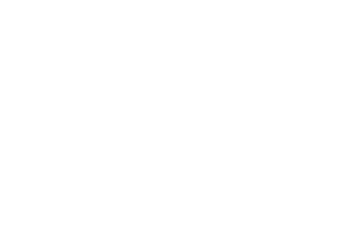

In [5]:
# 1000장 맞추기, train은 mosaic / scale로 인해 12배만 생성(48개는 해상도대비 너무 작아진다고 판단)
path_im = '/content/dairy-2/train/images'
path_lb = '/content/dairy-2/train/labels'
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))
crop_12(path_im,path_lb,476)
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))

In [8]:
# 기존 valid 이미지 수
path_im = '/content/dairy-2/valid/images'
path_lb = '/content/dairy-2/valid/labels'
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))

156 156


156 156


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

156 156


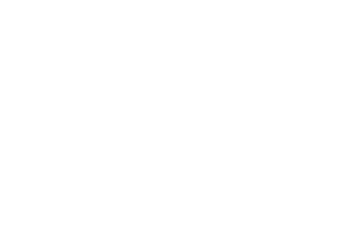

In [9]:
# 200장 맞추기
path_im = '/content/dairy-2/valid/images'
path_lb = '/content/dairy-2/valid/labels'
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))
crop_48(path_im,path_lb,32)
crop_12(path_im,path_lb,62)
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))

### 파일 병합

In [11]:
import os
import shutil

src_folder = "/content/dairy-2/train_aug/images"
dst_folder = "/content/dairy-2/train/images"

for file_name in os.listdir(src_folder):
    src_file = os.path.join(src_folder, file_name)
    dst_file = os.path.join(dst_folder, file_name)
    shutil.move(src_file, dst_file)

In [12]:
src_folder = "/content/dairy-2/train_aug/labels"
dst_folder = "/content/dairy-2/train/labels"

for file_name in os.listdir(src_folder):
    src_file = os.path.join(src_folder, file_name)
    dst_file = os.path.join(dst_folder, file_name)
    shutil.move(src_file, dst_file)

path_im = '/content/dairy-2/train/images'
path_lb = '/content/dairy-2/train/labels'
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))

1000 1000


In [15]:
src_folder = "/content/dairy-2/valid_aug/images"
dst_folder = "/content/dairy-2/valid/images"

for file_name in os.listdir(src_folder):
    src_file = os.path.join(src_folder, file_name)
    dst_file = os.path.join(dst_folder, file_name)
    shutil.move(src_file, dst_file)

In [16]:
src_folder = "/content/dairy-2/valid_aug/labels"
dst_folder = "/content/dairy-2/valid/labels"

for file_name in os.listdir(src_folder):
    src_file = os.path.join(src_folder, file_name)
    dst_file = os.path.join(dst_folder, file_name)
    shutil.move(src_file, dst_file)

path_im = '/content/dairy-2/valid/images'
path_lb = '/content/dairy-2/valid/labels'
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))

250 250


In [17]:
!rm -rf /content/dairy-2/train_aug
!rm -rf /content/dairy-2/valid_aug

In [22]:
%cd /content

/content


In [24]:
# 압축해서 저장 
import shutil

folder_to_zip = "dairy-2"
output_file = "dairy10"

shutil.make_archive(output_file, "zip", folder_to_zip)

'/content/dairy10.zip'

# 모델학습

In [ ]:
!pip install ultralytics